##### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import json

import sklearn.linear_model as lm
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from core.collector import Thunder
from core.calcs import Fire
from records.DBManager import DataManager


Probando la alerta

In [2]:
# Settings
with open('alert_settings.json', 'r') as f:
    settings = json.load(f)
metrics = settings['params']
metricsValues = [pd.DataFrame(settings[metric]) for metric in metrics]
coins = settings['coins']
upperLimit = pd.DataFrame([S.loc['over'] for S in metricsValues], index=metrics)
lowerLimit = pd.DataFrame([S.loc['under'] for S in metricsValues], index=metrics)
db = DataManager(test=True)
# Parametros
thunder = Thunder()
fires = {coin: Fire(coin, thunder.getWindow(coin)) for coin in coins}
history = pd.DataFrame([pd.Series({coin: 0 for coin in coins}, name=param) for param in metrics], index=metrics)

Corriendo en modo de prueba. Sin escritura en DB


Stocks

In [3]:
df = pd.DataFrame([f.updateData(True) for f in fires.values()]).T.append(pd.Series({coin: db.retrieveValuation(coin) for coin in coins}, name='self'))
# Indica si se generan cambios súbitos con respecto a la tendencia actual mediante EMA
df.loc['growth'] = (df.loc['price'] - df.loc['ema']) * 100 / df.loc['ema'] if 'growth' in metrics else [0] * len(coins)
# Diferencia entre el valor actual y mi valuación
df.loc['dif'] = (df.loc['price'] - df.loc['self']) * 100 / df.loc['self'] if 'dif' in metrics else [0] * len(coins)
# Comparativa con lo esperado durante 1 día
df.loc['day'] = (df.loc['price'] - df.loc['sma']) * 100 / df.loc['sma'] if 'day' in metrics else [0] * len(coins)
# Custom que es lo mismo que price
df.loc['custom'] = df.loc['price'] if 'custom' in metrics else [0] * len(scoins)

Observando los cambios

In [5]:
data = df.loc[metrics]
# data = pd.DataFrame({'btc': {'growth': 0.0037667715607046432, 'dif': 2.8085876887970334, 'day': -0.014012371204186302, 'custom': 12302.066}, 'eth': {'growth': -6.43093122084560833, 'dif': -10, 'day': -4.20988613465090547, 'custom': 300}, 'xrp': {'growth': -0.053453004088022255, 'dif': 4.51905907203806, 'day': -0.07332065514759091, 'custom': 0.31730786}, 'gnt': {'growth': 2.2032350524696529, 'dif': 11.32981371796274, 'day': 5.12102855251576536, 'custom': 0.108296285}, 'ltc': {'growth': -0.21071654846305324, 'dif': 0.7092799191096679, 'day': -0.24237467352209074, 'custom': 67.47026}})
tol = 0.3
up = pd.DataFrame([pd.Series(np.where(data.loc[metric] > upperLimit.loc[metric], data.loc[metric], 0), name=metric) for metric in metrics])
down = pd.DataFrame([pd.Series(np.where(-data.loc[metric] > upperLimit.loc[metric], -data.loc[metric], 0), name=metric) if 'custom' not in metric else pd.Series(np.where(data.loc[metric] < lowerLimit.loc[metric], data.loc[metric], 0), name=metric) for metric in metrics])
temp = up - down
temp.columns = coins
# En este punto ya tenemos las cosas que salen del "control"
print('Cambios generados:\n{}'.format(temp))
transition = pd.DataFrame([pd.Series(np.where(np.abs(temp.loc[metric] - history.loc[metric]) > tol, temp.loc[metric], history.loc[metric]), name=metric) for metric in metrics])
transition.columns = coins
print('Historico:\n{}\nTransición:\n{}\nHistory == transition {}'.format(history, transition, history.equals(transition)))
historicTemp = history
history = transition

Cambios generados:
        btc       eth  xrp       gnt       ltc
growth  0.0  0.000000  0.0  0.000000   0.00000
dif     0.0 -3.054457  0.0  0.000000   0.00000
day     0.0  0.000000  0.0  0.000000   0.00000
custom  0.0  0.000000  0.0  0.081314  63.04993
Historico:
        btc       eth  xrp  gnt       ltc
growth  0.0  0.000000  0.0  0.0   0.00000
dif     0.0 -3.054457  0.0  0.0   0.00000
day     0.0  0.000000  0.0  0.0   0.00000
custom  0.0  0.000000  0.0  0.0  63.04993
Transición:
        btc       eth  xrp  gnt       ltc
growth  0.0  0.000000  0.0  0.0   0.00000
dif     0.0 -3.054457  0.0  0.0   0.00000
day     0.0  0.000000  0.0  0.0   0.00000
custom  0.0  0.000000  0.0  0.0  63.04993
History == transition True


In [18]:
[print(row[row != 0]) for _, row in transition.iterrows()]

Series([], Name: growth, dtype: float64)
eth   -3.054457
Name: dif, dtype: float64
Series([], Name: day, dtype: float64)
ltc    63.04993
Name: custom, dtype: float64


[None, None, None, None]

##### Obteniendo data

In [2]:
# df = pd.read_json('data.json')
# df = df.dropna(axis=0)
thunder = Thunder()
df = thunder.getWindow('btc').dropna(axis=0)
# Asignando variables
tendency = df.apply(lambda x: x[['close', 'open']].mean(), axis=1)
df['G'] = (df['close'] - df['open']) * 100 / df[['close', 'open']].iloc[0].mean()

dates = np.array(df.index.astype(np.int64))
# Escaladores
dscaler = MinMaxScaler().fit(dates.reshape(-1, 1))
# Tendencia
tscaler = MinMaxScaler().fit(tendency.values.reshape(-1, 1))
# Cambios
gscaler = MinMaxScaler().fit(df['G'].values.reshape(-1, 1))

Definiendo indicadores EMA, SMA y MACD

In [3]:
def getEMA(window:int, data:pd.Series):
    ema = [data[0:window].mean()]
    [ema.append(value * (2 / (1 + window)) + ema[-1] * (1 - (2/(1+window)))) for value in data[window:].values]
    return pd.Series(ema, index=data.index[window-1:])

def getSMA(window: int, data:pd.Series):
    sma = [data[i:window + i].mean() for i in range(len(data)-window +1)]
    return pd.Series(sma, index=data.index[window-1:])

def getMACD(window1: int, window2: int, data: pd.Series):
    ema_w1 = getEMA(w1)
    ema_w2 = getEMA(w2)[-len(ema_w1):]
    macd = pd.Series([(e2 - e1) for (e2, e1) in np.c_[ema_w2.values, ema_w1.values]], index=ema_w1.index)
    sigline = getEMA(9, macd)
    hist = pd.Series([(e2 - e1) for (e2, e1) in np.c_[macd.values[-len(sigline):], sigline.values]], index=sigline.index)
    return macd, sigline, hist
    

### Proponiendo modelos lineales

Bayes unicamente con input de tiempo

In [4]:
# Modelo de bayes
n = 4
N = int(0.8* len(df))
x_train_subset = np.array(dates)[0:N]
y_train_subset = df['t'].values[0:N]
# Scaling and splitting
x_train, x_test, y_train, y_test = train_test_split(dscaler.transform(x_train_subset.reshape(-1, 1)), tscaler.transform(y_train_subset.reshape(-1, 1)), test_size=0.4)
# Fitting with a cubic poly
x_train = np.vander(x_train.reshape(-1), n + 1, increasing=True) 
x_test = np.vander(x_test.reshape(-1), n +1, increasing=True) 
# Introducing the model
bayRidge = lm.BayesianRidge(n_iter=1000 ,tol=1e-6, compute_score=True)
bayRidge.set_params(alpha_init=1, lambda_init=0.001)
bayRidge.fit(x_train, y_train.reshape(-1))
print('Scaled N:{}  train: {:.5f}   Test: {:.5f}  n_iter: {}'.format(n, bayRidge.score(x_train, y_train.reshape(-1)), bayRidge.score(x_test, y_test.reshape(-1)), bayRidge.n_iter_))
# Preparing the plot
x = dscaler.transform(dates.reshape(-1, 1)).reshape(-1)
x = np.vander(x, n + 1, True)
y_bayes_dates = tscaler.inverse_transform(bayRidge.predict(x).reshape(-1, 1))

Scaled N:4  train: 0.80874   Test: 0.77730  n_iter: 12


Modelo con SVM con fechas

In [5]:
# Primero, probando con data normal
N = int(0.5* len(df))
x_train_subset = np.array(dates)[0:N]
y_train_subset = df['tnorm'].values[0:N]
# Scaling and splitting
x_train, x_test, y_train, y_test = train_test_split(dscaler.transform(x_train_subset.reshape(-1, 1)), tscaler.transform(y_train_subset.reshape(-1, 1)), test_size=0.5)
# Dandole algo de forma
x_train = np.vander(x_train.reshape(-1), 5, increasing=True) 
x_test = np.vander(x_test.reshape(-1), 5, increasing=True) 
# Introducing model
# svr_poly = svm.SVR(kernel='poly', coef0=0.5, degree=6, C=1000, gamma=0.75)
svr_rbf = svm.SVR(kernel='rbf', C=20000, gamma=0.8)
# Fitting data
# svr_poly.fit(x_train, y_train.reshape(-1))
svr_rbf.fit(x_train, y_train.reshape(-1))
# print('PolySVR train: {:.5f}   Test: {:.5f}'.format(svr_poly.score(x_train, y_train.reshape(-1)), svr_poly.score(x_test, y_test.reshape(-1))))
print('rbfSVR train: {:.5f}   Test: {:.5f}'.format(svr_rbf.score(x_train, y_train.reshape(-1)), svr_rbf.score(x_test, y_test.reshape(-1))))
x = dscaler.transform(dates.reshape(-1, 1)).reshape(-1)
x = np.vander(x, 5, True)
y_svm_dates = tscaler.inverse_transform(svr_rbf.predict(x).reshape(-1, 1)) #, tscaler.inverse_transform(svr_poly.predict(x).reshape(-1, 1))
x = dscaler.transform(dates[N:].reshape(-1, 2)).reshape(-1)
x = np.vander(x, 5, True)
y = tscaler.transform(df['tnorm'].values[N:].reshape(-1, 1)).reshape(-1)
print('Real test: {:.5f}'.format(svr_rbf.score(x, y)))

rbfSVR train: -0.18243   Test: -0.18165


ValueError: cannot reshape array of size 713 into shape (2)

In [ ]:
plt.plot(df.index, df['t'])
plt.plot(df.index, y_bayes_dates, label='Bayes date')
plt.plot(df.index, y_svm_dates, label='SVM date')
plt.vlines(dates[N], -0.1, 0.1)
plt.legend(frameon=False)
plt.ylim([-0.1, 0.1])
plt.xlim([dates[0], dates[int(0.7 * len(df))]])

Ingresando los valores t-1 para predecir t
Y no, no estamos afectando la parte de time machine paradox.
Por lo pronto ingresaremos todos los datos conocidos así como sma y ema en ventanas de 10

In [8]:
# X: [date, open, close, volume, ema, sma]
ema = getEMA(10, df['close'])
sma = getSMA(10, df['close'])
n = len(ema) # debe ser len(df) - window
# X = np.c_[dates[-n:-1], df['open'].values[-n:-1], df['close'].values[-n:-1], df['volume'].values[-n:-1], ema[:-1], sma[:-1]]
# X = np.c_[df['open'].values[-n:-1], df['close'].values[-n:-1], df['volume'].values[-n:-1], ema[:-1], sma[:-1]]
# Probando una aproximación distinta
X = np.c_[dates[-n:-1], df['t'].values[-n:-1], ema[:-1], sma[:-1]]
y = df['t'].values[1-n:].reshape(-1, 1)
# Ahora agregamos un escalador
x_scaler = MinMaxScaler().fit(X)
y_scaler = MinMaxScaler().fit(y)
x_train, x_test, y_train, y_test = train_test_split(x_scaler.transform(X), y_scaler.transform(y), test_size=0.35)


In [9]:
# Nuevamente con Bayes
bayRidge = lm.BayesianRidge(tol=1e-6, compute_score=True)
bayRidge.set_params(alpha_init=1, lambda_init=0.001)
bayRidge.fit(x_train, y_train.reshape(-1))
print('Scaled N:{}  train: {:.5f}   Test: {:.5f}  n_iter: {}'.format(n, bayRidge.score(x_train, y_train.reshape(-1)), bayRidge.score(x_test, y_test.reshape(-1)), bayRidge.n_iter_))
y_bayes_data = pd.Series(y_scaler.inverse_transform(bayRidge.predict(x_scaler.transform(X)).reshape(-1, 1)).reshape(-1), index=dates[-len(y):])

Scaled N:1432  train: 0.99467   Test: 0.99540  n_iter: 4


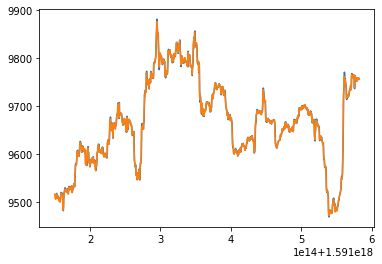

In [10]:
plt.plot(dates[-len(y_bayes_data):], y_bayes_data)
plt.plot(dates, df['t'])

Primero debemos obtener un modelo para la predicción de volumenes

In [34]:
X = np.array([df['volume'].values[i: i+5] for i in range(len(df) - 6)])
y = np.array([df['volume'].values[i] for i in range(6, len(df))]).reshape(-1 , 1)
# Definidos los arrays pasamos con los escalamientos
x_scaler = MinMaxScaler().fit(X)
y_scaler = MinMaxScaler().fit(y)
# Ahora hacemos los splits de entrenamiento
x_train, x_test, y_train, y_test = train_test_split(x_scaler.transform(X), y_scaler.transform(y), test_size=0.25)
# Bayesiano
# Nuevamente con Bayes
bayRidge = lm.BayesianRidge(tol=1e-6, compute_score=True)
bayRidge.set_params(alpha_init=1, lambda_init=0.001)
bayRidge.fit(x_train, y_train.reshape(-1))
print('Scaled N:{}  train: {:.5f}   Test: {:.5f}  n_iter: {}'.format(n, bayRidge.score(x_train, y_train.reshape(-1)), bayRidge.score(x_test, y_test.reshape(-1)), bayRidge.n_iter_))
y_bayes_data = pd.Series(y_scaler.inverse_transform(bayRidge.predict(x_scaler.transform(X)).reshape(-1, 1)).reshape(-1), index=dates[-len(y):])

svr_rbf = svm.SVR(kernel='rbf', C=20000, gamma=0.8)
# Fitting data
svr_rbf.fit(x_train, y_train.reshape(-1))
print('rbfSVR train: {:.5f}   Test: {:.5f}'.format(svr_rbf.score(x_train, y_train.reshape(-1)), svr_rbf.score(x_test, y_test.reshape(-1))))
y_svm_dates = tscaler.inverse_transform(svr_rbf.predict(x).reshape(-1, 1)) #, tscaler.inverse_transform(svr_poly.predict(x).reshape(-1, 1))

Scaled N:1143  train: 0.05193   Test: 0.00694  n_iter: 6
rbfSVR train: -0.09668   Test: -0.40174


Premisa: Calcular/Predecir los datos siguientes a partir de un modelo determinado basados en volumen, tendencia, ema y dates

In [91]:
# Train data sera el 80% de los datos
N = int(0.8 * len(df))
train_df = df.iloc[0:N]
train_dates = dates[0:N]
# Calculando EMA
ema = getEMA(10, train_df['t'])
n = len(ema) # debe ser len(df) - window
# X: [date, t, volume, ema]
X = np.c_[train_dates[-n:-1], ema.values[:-1], train_df['t'].values[-n:-1]]#, train_df['volume'].values[-n:]]
y = train_df['t'].values[1-n:].reshape(-1, 1)
# Escaladores
x_scaler = MinMaxScaler().fit(X)
y_scaler = MinMaxScaler().fit(y)
# Ahora hacemos los splits de entrenamiento
x_train, x_test, y_train, y_test = train_test_split(x_scaler.transform(X), y_scaler.transform(y), test_size=0.25)
# Bayesiano
# Nuevamente con Bayes
bayRidge = lm.BayesianRidge(tol=1e-6, compute_score=True)
bayRidge.set_params(alpha_init=1, lambda_init=0.001)
bayRidge.fit(x_train, y_train.reshape(-1))
print('Scaled N:{}  train: {:.5f}   Test: {:.5f}  n_iter: {}'.format(n, bayRidge.score(x_train, y_train.reshape(-1)), bayRidge.score(x_test, y_test.reshape(-1)), bayRidge.n_iter_))
y_bayes_data = pd.Series(y_scaler.inverse_transform(bayRidge.predict(x_scaler.transform(X)).reshape(-1, 1)).reshape(-1), index=dates[-len(y):])
# Ahora viene lo chido...
test_df = df.iloc[N:]
test_dates = dates[N:]
# para el calculo de EMA
x_tendency = df['t'].values[:N]
y_bayes_test = []
for k in range(len(test_df)-1):
    # constructing series
    try:
        x_temp = pd.Series(x_tendency, index=dates[:N+k])
        ema = getEMA(10, x_temp)
        # Definiendo X
        X = x_scaler.transform(np.array([test_dates[k], ema.values[-1], x_tendency[-1]]).reshape(1, -1))
        temp = y_scaler.inverse_transform(bayRidge.predict(X).reshape(1, -1)).reshape(-1)
        x_tendency = np.append(x_tendency, temp)
        y_bayes_test.append(temp[0])
    except ValueError:
        break    


Scaled N:1143  train: 0.96729   Test: 0.97046


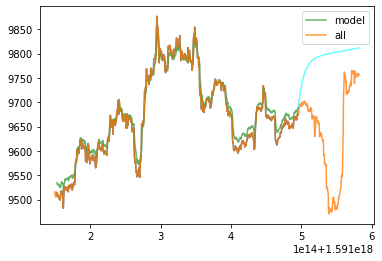

In [98]:
plt.plot(train_dates[1-n:], y.reshape(-1))
plt.plot(train_dates[1-n:], y_bayes_data.values.reshape(-1), label='model', color='g', alpha=0.6)
plt.plot(dates, df['t'].values, label='all', alpha=0.8)
plt.plot(test_dates[1:], y_bayes_test, color='cyan', alpha=0.6)
plt.legend()
xlim = plt.xlim()

Intentando solo con los EMA en ventanas de 10

In [ ]:
# Train data sera el 80% de los datos
N = int(0.8 * len(df))
train_df = df.iloc[0:N]
train_dates = dates[0:N]
# Calculando EMA
ema = getEMA(10, train_df['t'])
n = len(ema) # debe ser len(df) - window
# X: [date, t, volume, ema]
X = np.c_[train_dates[-n:-1], ema.values[:-1], train_df['t'].values[-n:-1]]#, train_df['volume'].values[-n:]]
y = train_df['t'].values[1-n:].reshape(-1, 1)
# Escaladores
x_scaler = MinMaxScaler().fit(X)
y_scaler = MinMaxScaler().fit(y)
# Ahora hacemos los splits de entrenamiento
x_train, x_test, y_train, y_test = train_test_split(x_scaler.transform(X), y_scaler.transform(y), test_size=0.25)
# Bayesiano
# Nuevamente con Bayes
bayRidge = lm.BayesianRidge(tol=1e-6, compute_score=True)
bayRidge.set_params(alpha_init=1, lambda_init=0.001)
bayRidge.fit(x_train, y_train.reshape(-1))
print('Scaled N:{}  train: {:.5f}   Test: {:.5f}  n_iter: {}'.format(n, bayRidge.score(x_train, y_train.reshape(-1)), bayRidge.score(x_test, y_test.reshape(-1)), bayRidge.n_iter_))
y_bayes_data = pd.Series(y_scaler.inverse_transform(bayRidge.predict(x_scaler.transform(X)).reshape(-1, 1)).reshape(-1), index=dates[-len(y):])
# Ahora viene lo chido...
test_df = df.iloc[N:]
test_dates = dates[N:]
# para el calculo de EMA
x_tendency = df['t'].values[:N]
y_bayes_test = []
for k in range(len(test_df)-1):
    # constructing series
    try:
        x_temp = pd.Series(x_tendency, index=dates[:N+k])
        ema = getEMA(10, x_temp)
        # Definiendo X
        X = x_scaler.transform(np.array([test_dates[k], ema.values[-1], x_tendency[-1]]).reshape(1, -1))
        temp = y_scaler.inverse_transform(bayRidge.predict(X).reshape(1, -1)).reshape(-1)
        x_tendency = np.append(x_tendency, temp)
        y_bayes_test.append(temp[0])
    except ValueError:
        break    